In [38]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


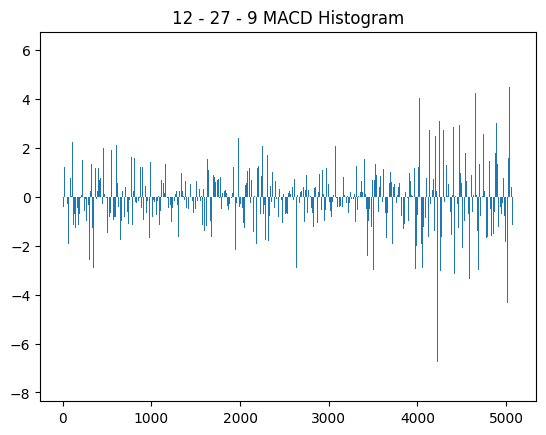

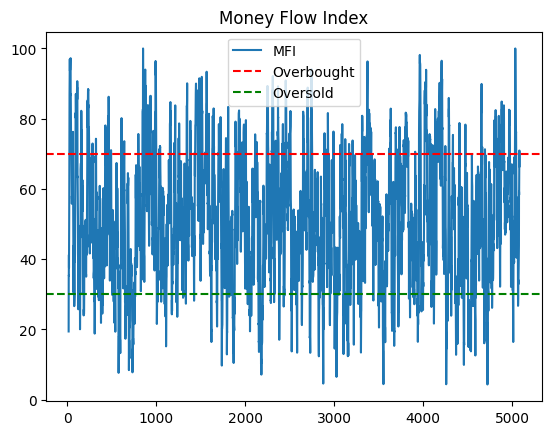

5041
1681
                            OLS Regression Results                            
Dep. Variable:      3 Period % Change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.147
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.332
Time:                        09:17:03   Log-Likelihood:                 3822.2
No. Observations:                1680   AIC:                            -7634.
Df Residuals:                    1675   BIC:                            -7607.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.005     -1.45

Price,Adj Close,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,...,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB,RSI,Close + 3,3 Period % Change,Predictions,Residuals
0,303.829987,303.829987,307.833344,303.061981,306.183319,2830473,299.605698,292.858853,6.746845,6.631616,...,295.517035,7.834352,311.185739,279.848331,0.234728,65.579934,300.556671,-0.010774,0.001348,0.012122
1,300.556671,300.556671,303.263336,300.323334,303.153351,1864844,300.781101,294.877263,5.903838,6.451648,...,298.445370,6.024495,310.494361,286.396380,0.412387,54.436710,306.273346,0.019020,0.001025,-0.017995
2,306.273346,306.273346,307.323334,303.333344,304.456665,2958157,302.474521,296.940975,5.533546,6.037817,...,301.085315,4.041318,309.167951,293.002679,0.179063,55.862181,308.130005,0.006062,0.000570,-0.005492
3,308.130005,308.130005,309.298401,306.839996,308.730011,2247506,304.696330,299.201790,5.494540,5.788923,...,303.080826,3.578765,310.238356,295.923296,0.147282,72.562143,305.466949,-0.008643,0.002270,0.010913
4,305.466949,305.466949,309.500000,305.000000,309.029999,4442980,305.674100,300.826805,4.847295,5.453434,...,303.770338,3.887185,311.544709,295.995968,0.390884,52.786845,307.200226,0.005674,0.000758,-0.004916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,324.989990,324.989990,325.419098,322.250000,323.420013,11278607,322.099770,322.858930,-0.759160,-0.122202,...,325.076328,5.380204,335.836735,314.315920,0.504012,41.910436,323.940002,-0.003231,-0.000018,0.003213
1677,323.940002,323.940002,325.000000,320.350006,322.040009,11175979,322.662768,322.996406,-0.333638,-0.269966,...,324.305527,5.087198,334.479922,314.131131,0.517963,40.209173,320.193604,-0.011565,-0.000702,0.010863
1678,320.193604,320.193604,332.359985,318.420013,327.809998,34193830,322.159896,322.688422,-0.528527,-0.346353,...,323.249782,4.737854,332.725490,313.774074,0.661264,45.294053,321.480011,0.004018,0.000253,-0.003765
1679,321.480011,321.480011,325.920013,321.440002,323.339996,11858956,321.940817,322.462834,-0.522017,-0.452508,...,321.929033,3.664009,329.257050,314.601015,0.530637,54.949598,322.170013,0.002146,0.000938,-0.001208


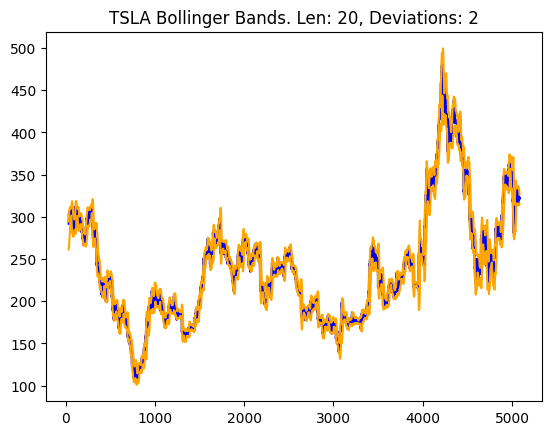

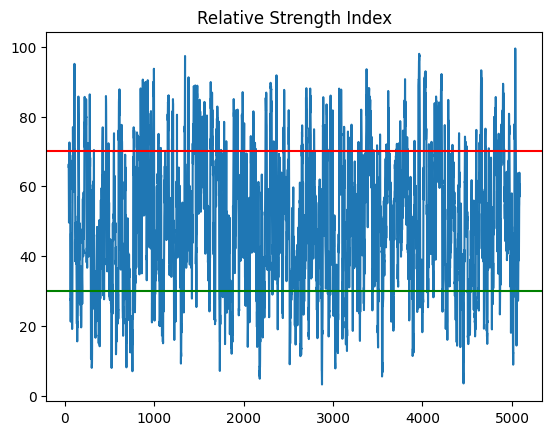

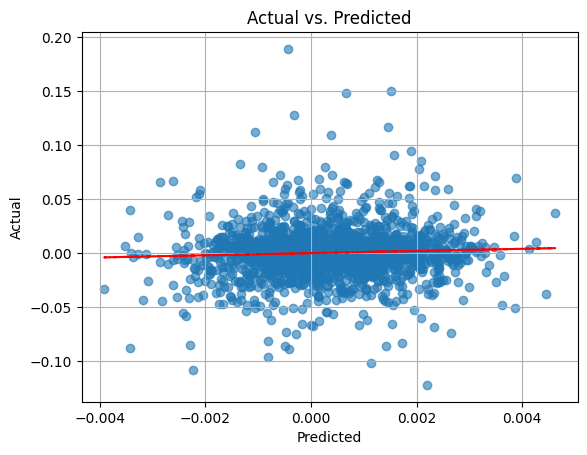

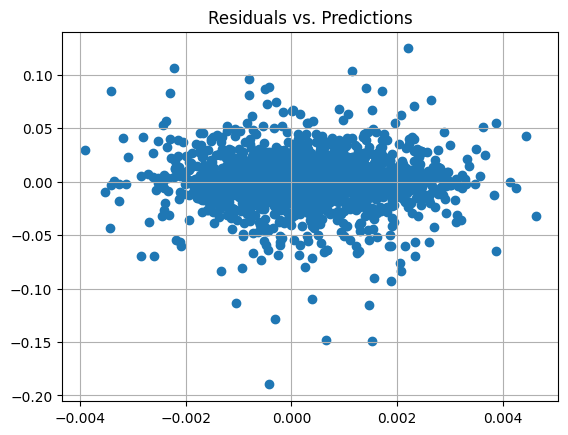

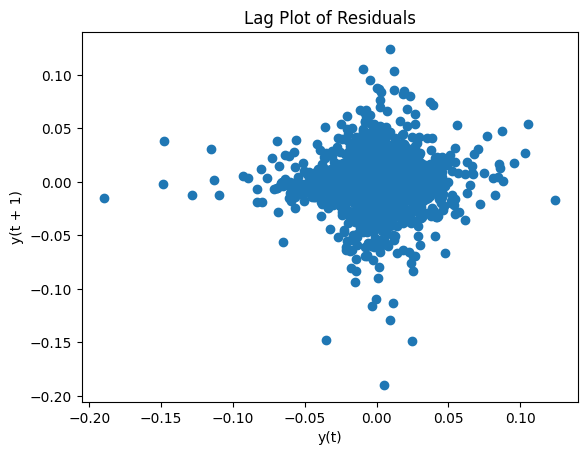

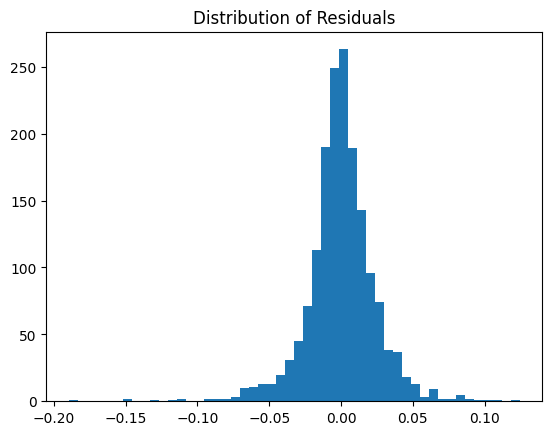

In [ ]:
TICKER = 'TSLA'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 3
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_LENGTH = 14
RSI_OVERBOUGHT = 7  0
RSI_OVERSOLD = 30
BB_LEN = 20
DEVS = 2

# what subsetion of that data are you interested in
LOOKBACK = 10000

STRATEGY = ['MACD_hist', 'MFI', 'BB', 'RSI']

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df['BB'] = (df['Upper_Band'] - df['Close']) / (df['Upper_Band'] - df['Lower_Band'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

# this gets rid of autocorrelation when we shift multiple periods
def fix_autocorrelation(df, interval=SHIFT):

    print(len(df))

    df = df.iloc[::interval].reset_index(drop=True)
    print(len(df))
    return df

def generate_regression_output(df, features=STRATEGY, target=f'{SHIFT} Period % Change'):
    subset = df[features + [target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficients = model.params.drop('const')
    r2 = model.rsquared
    p_values = model.pvalues.drop('const')
    model_p_value = model.f_pvalue  # overall model significance
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())

    # Plot actual vs predicted
    plt.figure()
    plt.scatter(y_pred, y, alpha=0.6)
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)

    return df, intercept, coefficients, model_p_value

def validate_regression_output(df, coef, intercept):
    df['Predictions'] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature]

    df['Residuals'] = df['Predictions'] - df[f'{SHIFT} Period % Change']

    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Residuals vs. Predictions')
    plt.grid(True)

    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals')

    plt.figure()
    plt.hist(df['Residuals'].dropna(), bins=50)
    plt.title('Distribution of Residuals')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df = fix_autocorrelation(df)
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)

    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df